In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import glob,gc
from copy import deepcopy

In [2]:
! ls /work/FAC/FGSE/IDYST/tbeucler/default/saranya/Data/SHIPS/5day

SHIPS_5day_timeseries_cpac.csv	SHIPS_predictors_full_nat.csv
SHIPS_5day_timeseries_epac.csv	SHIPS_predictors_full_southhem.csv
SHIPS_5day_timeseries_natl.csv	SHIPS_predictors_full_wpac.csv
SHIPS_5day_timeseries_nio.csv	lsdiag_cpac_1982_2019_sat_ts.dat
SHIPS_5day_timeseries_shem.csv	lsdiag_epac_1982_2019_sat_ts.dat
SHIPS_5day_timeseries_wpac.csv	lsdiag_na_1982_2019_sat_ts.dat
SHIPS_predictors_full_NIO.csv	lsdiag_nio_1990_2017.dat
SHIPS_predictors_full_cpac.csv	lsdiag_sh_1998_2017.dat
SHIPS_predictors_full_epac.csv	lsdiag_wpac_1990_2017.dat


In [3]:
! ls /work/FAC/FGSE/IDYST/tbeucler/default/raw_data/CIRA/primed/2017

AL  EP	IO  SH	WP


In [2]:
from netCDF4 import Dataset
IBTRACS = pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/milton/repos/alpha_bench/tracks/ibtracs/ibtracs.ALL.list.v04r00.csv')#['USA_ATCF_ID']
IBTRACS_TC_ID = IBTRACS['USA_ATCF_ID']
IBTRACS_TC_WINDS = IBTRACS['USA_WIND']
IBTRACS_STATUS = IBTRACS['USA_STATUS']

/tmp/46001107/ipykernel_1517079/3035213046.py:2: DtypeWarning: Columns (1,2,8,9,14,19,20,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  IBTRACS = pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/milton/repos/alpha_bench/tracks/ibtracs/ibtracs.ALL.list.v04r00.csv')#['USA_ATCF_ID']


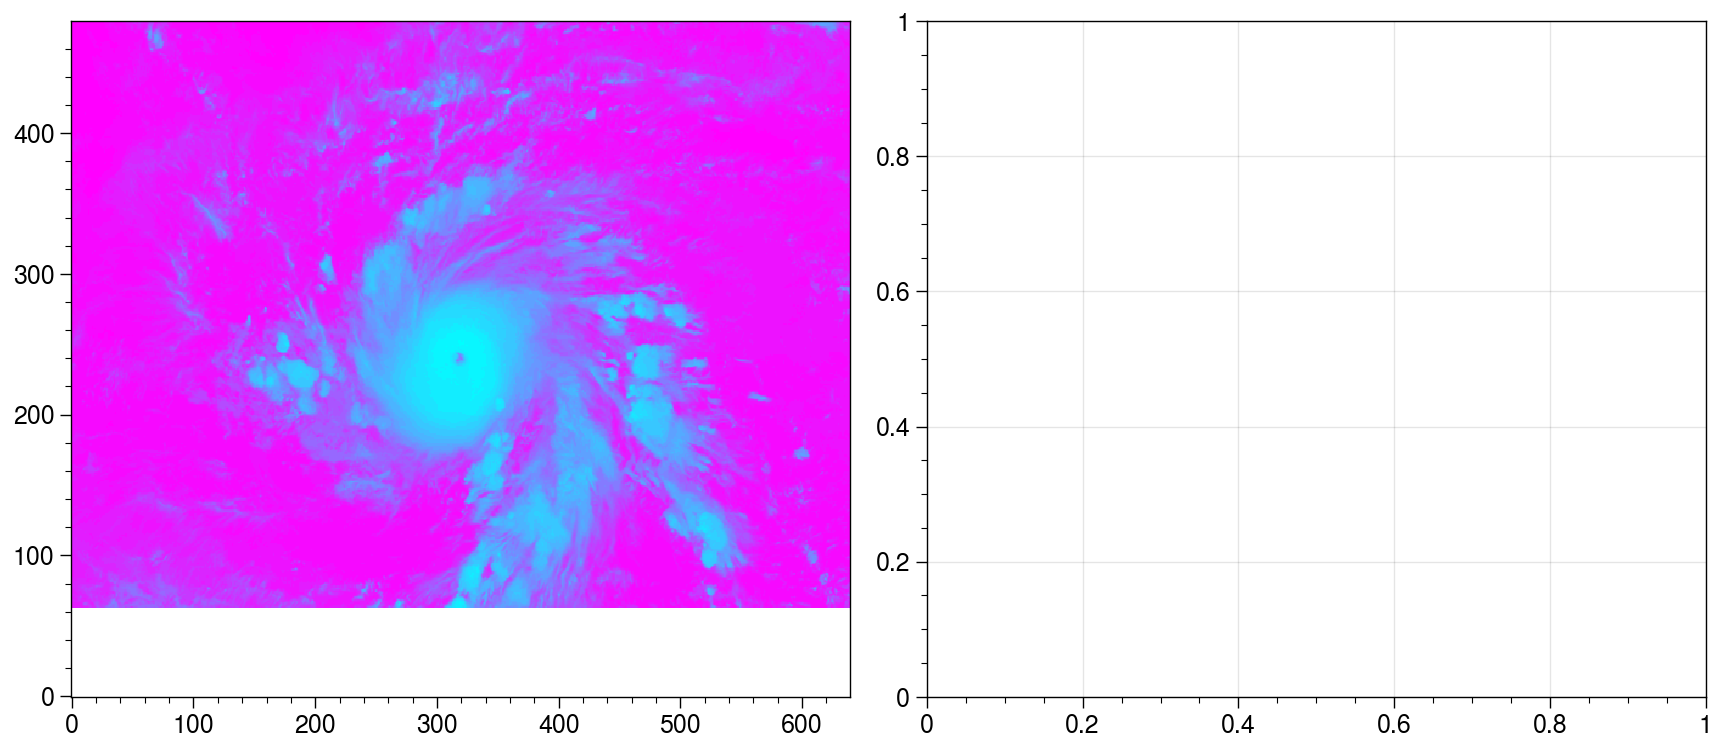

In [8]:
aaa = Dataset(sorted(glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/CIRA/primed/{year}/{basin}/{num}/TCPRIMED_v01r00-final_{basin}{num}{year}_SSMIS*.nc'))[3])['infrared']['IRWIN']
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.895,refaspect=1.1531,sharex=1,sharey=1)
axs[0].pcolormesh(aaa,levels=31,cmap='cool')
plt.show()

In [5]:
#WP_33
#2007_OLGA	[al172007, AL_17] 2010_IGOR AL_11
#2012_BOPHA WP_26
year = 2012
basin = 'WP'
num='26'
test_tcprimed = Dataset(glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/CIRA/primed/{year}/{basin}/{num}/TCPRIMED_v01r00-final_{basin}{num}{year}_era5*.nc')[0])
#storm = IBTRACS[IBTRACS['USA_ATCF_ID']==test.automated_tropical_cyclone_forecasting_system_storm_identifier.upper()]#['USA_WIND']
#list(storm['USA_STATUS'])
#storm['USA_WIND'] = storm['USA_WIND'].astype(int)
#firstindex = (storm[(storm['USA_STATUS'])=='TS'])['USA_STATUS'].first_valid_index()
#len(storm.loc[:int(firstindex)]['USA_STATUS'])

In [10]:
for i in range(len(test_tcprimed['rectilinear']['precipitable_water'])):
    fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.895,refaspect=1.1531,sharex=1,sharey=1)
    axs[0].pcolormesh(test_tcprimed['rectilinear']['precipitable_water'][i],vmin=0,vmax=test_tcprimed['rectilinear']['precipitable_water'][i].max(),levels=41,cmap='Blues')
    axs[0].quiver(np.linspace(0,80,81)[::4],np.linspace(0,80,81)[::4],\
                  test_tcprimed['rectilinear']['u_wind'][i,-5,::4,::4],test_tcprimed['rectilinear']['v_wind'][i,-5,::4,::4],c='yellow',lw=1.5)
    #aaa = Dataset(sorted(glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/CIRA/primed/{year}/{basin}/{num}/TCPRIMED_v01r00-final_{basin}{num}{year}_SSMIS*.nc'))[i])
    #axs[1].pcolormesh(aaa['infrared']['IRWIN'][:],levels=81,cmap='Fire')
    axs[1].pcolormesh(test_tcprimed['rectilinear']['rain_convective'][i],vmin=0,vmax=test_tcprimed['rectilinear']['rain_convective'][i].max(),levels=41,cmap='Fire')
    axs[1].quiver(np.linspace(0,80,81)[::4],np.linspace(0,80,81)[::4],\
                  test_tcprimed['rectilinear']['u_wind'][i,-5,::4,::4],test_tcprimed['rectilinear']['v_wind'][i,-5,::4,::4],c='k',lw=1.5)
    plt.savefig(f'./fig/bopha/bopha_{i}.png',dpi=600)
    plt.close()

In [57]:
yeardict = []
basin = 'WP'
for year in tqdm(np.arange(1998,2021,1)):
    stormnum = [obj.split('/')[-1] for obj in glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/CIRA/primed/{year}/{basin}/*')]
    stormdict,shear2dict,latdict,intensity_dict,id_dict = {},{},{},{},{}
    for num in stormnum:
        test = Dataset(glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/CIRA/primed/{year}/{basin}/{num}/TCPRIMED_v01r00-final_{basin}{num}{year}_era5*.nc')[0])
        storm = IBTRACS[IBTRACS['USA_ATCF_ID']==test.automated_tropical_cyclone_forecasting_system_storm_identifier.upper()]#['USA_WIND']
        try:
            stormname = storm['NAME'].unique()[0]
            firstindex = (storm[(storm['USA_STATUS'])=='TS'])['USA_STATUS'].first_valid_index()
            if basin=='WP':
                secondindex = (storm[(storm['USA_STATUS'])=='TY'])['USA_STATUS'].first_valid_index()
            elif (basin=='EP' or basin=='AL'):
                secondindex = (storm[(storm['USA_STATUS'])=='HU'])['USA_STATUS'].first_valid_index()
            numindex = len(storm.loc[:int(firstindex)]['USA_STATUS'])
            stormdict[f'{year}_{stormname}'] = test['diagnostics']['shear_magnitude'][:,1,1][:int(np.round(numindex/2))]
            if secondindex is not None:
                numindex_hr = len(storm.loc[int(firstindex):int(secondindex)]['USA_STATUS'])
                shear2dict[f'{year}_{stormname}'] = test['diagnostics']['shear_magnitude'][:,1,1][int(np.round(numindex/2)):int(np.round(numindex/2))+int(np.round(numindex_hr/2))]
            else:
                secondindex_end = (storm[(storm['USA_STATUS'])=='TS'])['USA_STATUS'].last_valid_index()
                numindex_hr = len(storm.loc[int(firstindex):int(secondindex_end)]['USA_STATUS'])
                shear2dict[f'{year}_{stormname}'] = test['diagnostics']['shear_magnitude'][:,1,1][int(np.round(numindex/2)):int(np.round(numindex/2))+int(np.round(numindex_hr/2))]                
            latdict[f'{year}_{stormname}'] = storm.loc[int(firstindex)]['LAT']
            id_dict[f'{year}_{stormname}'] = [test.automated_tropical_cyclone_forecasting_system_storm_identifier,f'{basin}_{num}']
            intensity_dict[f'{year}_{stormname}'] = float(storm['USA_WIND'].max())
        except:
            break
            
    hrshear,hr_time = [],[]
    for key in shear2dict.keys():
        stm_hr = shear2dict[key]
        try:
            hrshear.append(stm_hr.mean())
            hr_time.append(len(stm_hr)*6)
        except:
            hrshear.append(np.nan)
            hr_time.append(np.nan)
            
    dicti = pd.DataFrame(list(
        zip(stormdict.keys(),
            [id_dict[key] for key in id_dict],
            [stormdict[key].mean() for key in stormdict.keys()],
            [len(stormdict[key])*6 for key in stormdict.keys()],
            hrshear,
            hr_time,
            [latdict[key] for key in latdict.keys()],
            [intensity_dict[key] for key in intensity_dict.keys()]
           )
    ), columns = ['name','id','mean_shear','time_before_tcg','mean_shear_hu','time_before_hu','lat','final_inten']
                )
    del test
    gc.collect()
    yeardict.append(dicti)

  0%|          | 0/23 [00:00<?, ?it/s]

In [58]:
#from datetime import datetime, timezone
#datetime.fromtimestamp(test['diagnostics']['time'][1].data, timezone.utc)
test = pd.concat(yeardict,join='outer',axis=0).dropna().reset_index()
read_and_proc.save_to_pickle(f'./store/{basin}_shear.pkl',pd.concat(yeardict,join='outer',axis=0).dropna().reset_index(),'PICKLE')

# Read all files

In [3]:
WP = read_and_proc.depickle('./store/WP_shear.pkl')
EP = read_and_proc.depickle('./store/EP_shear.pkl')
AL = read_and_proc.depickle('./store/AL_shear.pkl')
IO = read_and_proc.depickle('./store/IO_shear.pkl')

In [5]:
EP['year'] = [int(obj[:4]) for obj in EP['name']]
AL['year'] = [int(obj[:4]) for obj in AL['name']]

In [6]:
EP_filt = EP[EP['year']>=2000].reset_index().drop('level_0',axis=1)
AL_filt = AL[AL['year']>=2000].reset_index().drop('level_0',axis=1)

In [16]:
(AL_filt[AL_filt['year']==2005])

,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,final_inten,year
66,0,2005_BRET,"[al022005, AL_02]",8.321125,12,7.393698,24,19.9,35.0,2005
67,1,2005_EMILY,"[al052005, AL_05]",6.090113,24,5.171079,48,11.0,97.0,2005
68,2,2005_HARVEY,"[al082005, AL_08]",8.340963,12,13.160768,138,29.5,55.0,2005
69,3,2005_VINCE,"[al242005, AL_24]",11.565655,36,9.354990,12,33.8,65.0,2005
70,4,2005_BETA,"[al272005, AL_27]",0.739194,12,5.613429,48,11.0,95.0,2005
71,5,2005_JOSE,"[al112005, AL_11]",4.884573,12,5.721584,18,19.6,50.0,2005
72,6,2005_MARIA,"[al142005, AL_14]",6.612386,24,4.861683,48,21.1,95.0,2005
73,7,2005_PHILIPPE,"[al172005, AL_17]",5.192062,12,10.776713,36,13.5,70.0,2005
74,8,2005_ZETA,"[al312005, AL_31]",20.139232,12,33.930566,168,24.2,55.0,2005
75,9,2005_ARLENE,"[al012005, AL_01]",7.325410,12,10.646240,72,18.2,60.0,2005


In [7]:
import seaborn as sns

In [12]:
allnp = pd.concat([WP,EP_filt,AL_filt],join='outer',axis=0).reset_index()

In [14]:
print(list(filt_allnp_major_shear['name']))

['2000_SHANSHAN', '2000_SAOMAI', '2000_BILIS', '2001_KROSA', '2001_LINGLING', '2001_TORAJI', '2001_DANAS', '2001_FAXAI', '2001_CHEBI', '2001_LEKIMA', '2001_PODUL', '2001_WUTIP', '2001_FRANCISCO', '2001_MAN-YI', '2002_HAGIBIS', '2002_CHATAAN', '2002_RUSA', '2002_PHANFONE', '2002_RAMMASUN', '2002_SINLAKU', '2002_HIGOS', '2002_FENGSHEN', '2002_HALONG', '2003_KUJIRA', '2003_ETAU', '2003_DUJUAN', '2003_CHAN-HOM', '2003_LUPIT', '2003_KETSANA', '2004_CHABA', '2004_DIANMU', '2004_NIDA', '2004_CONSON', '2004_MA-ON', '2004_SUDAL', '2004_SONGDA', '2004_MEARI', '2004_NOCK-TEN', '2005_NABI', '2005_NESAT', '2005_TALIM', '2006_CHANCHU', '2006_SAOMAI', '2006_DURIAN', '2006_EWINIAR', '2006_CHEBI', '2006_CIMARON', '2006_UTOR', '2006_XANGSANE', '2007_YUTU', '2007_USAGI', '2007_MITAG', '2007_KAJIKI', '2007_KROSA', '2007_KONG-REY', '2007_SEPAT', '2008_NEOGURI', '2008_JANGMI', '2008_FENGSHEN', '2008_NURI', '2008_RAMMASUN', '2008_NAKRI', '2008_SINLAKU', '2008_HAGUPIT', '2009_VAMCO', '2009_PARMA', '2009_NIDA'

In [13]:
filt_allnp = allnp[allnp['lat']<20]
filt_allnp_major = filt_allnp[filt_allnp['final_inten']>=95]
filt_allnp_major_shear = filt_allnp_major[filt_allnp_major['mean_shear']<=11]

In [17]:
filt_allnp_major_shear.drop('final_inten',axis=1).drop('year',axis=1).to_csv('./store/stormlist.csv')

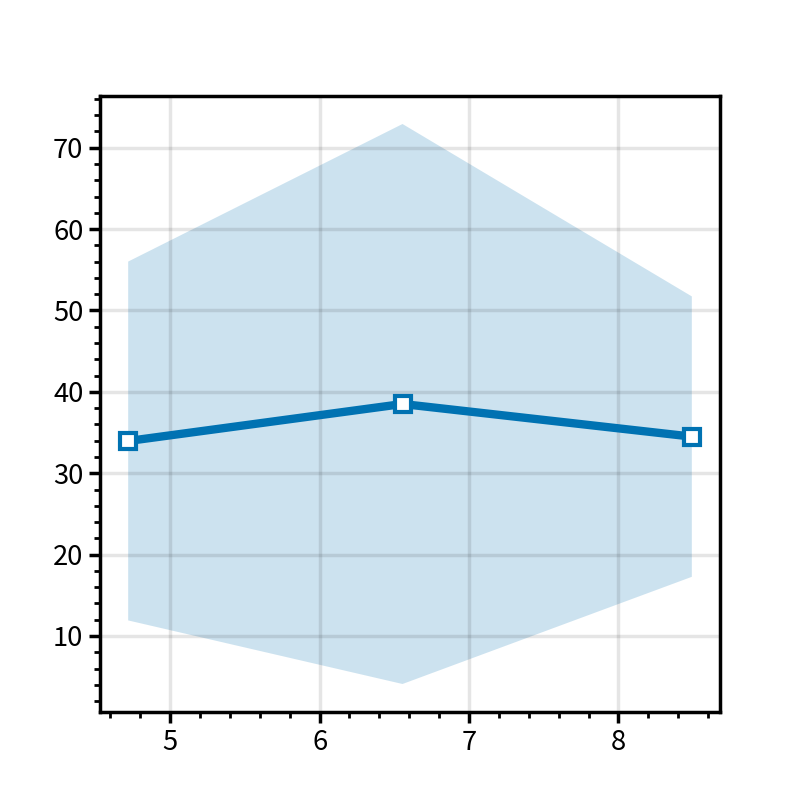

In [81]:
percentiles_tcg = np.asarray([np.percentile(filt_allnp['mean_shear'],obj) for obj in np.linspace(0,100,6)])
mean = [filt_allnp.loc[(filt_allnp['mean_shear']>percentiles[i]) & (filt_allnp['mean_shear']<percentiles[i+1])]['time_before_tcg'].mean() for i in range(len(percentiles_tcg)-1)]
std = [filt_allnp.loc[(filt_allnp['mean_shear']>percentiles[i]) & (filt_allnp['mean_shear']<percentiles[i+1])]['time_before_tcg'].std() for i in range(len(percentiles_tcg)-1)]
plt.plot(percentiles_tcg[1:],np.asarray(mean),lw=3,marker='s',mfc='w',mew=1.5)
plt.fill_between(percentiles_tcg[1:],
                 np.asarray(mean)-np.asarray(std),
                 np.asarray(mean)+np.asarray(std),
                 alpha=0.2
                )
plt.show()

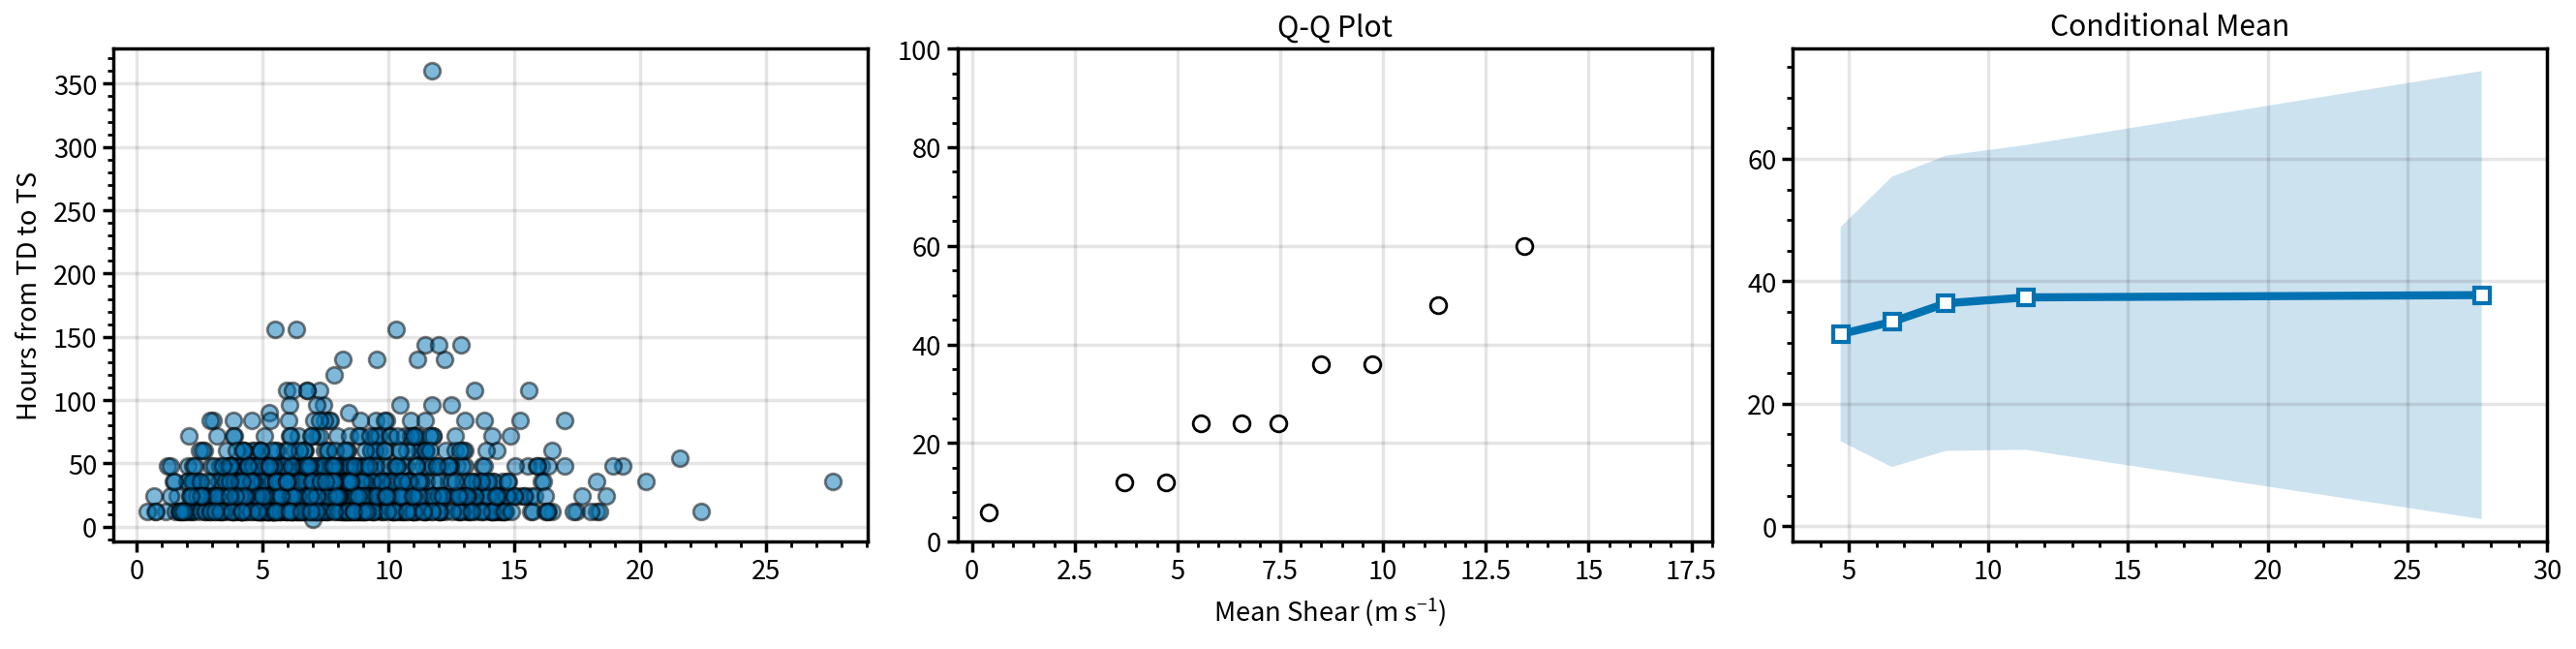

In [90]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.895,refaspect=1.531,sharex=1,sharey=1)
axs[0].scatter(filt_allnp['mean_shear'],filt_allnp['time_before_tcg'],linewidths=1,edgecolors='k',alpha=0.5)

percentiles = np.linspace(0,100,11)[:-1]
qn_a = np.asarray([np.percentile(filt_allnp['mean_shear'],obj) for obj in percentiles])
qn_b = np.asarray([np.percentile(filt_allnp['time_before_tcg'],obj) for obj in percentiles])
axs[1].plot([np.percentile(filt_allnp['mean_shear'],obj) for obj in percentiles],\
         [np.percentile(filt_allnp['time_before_tcg'],obj) for obj in percentiles],
         lw = 0,
         mfc = 'w',
         mec = 'k',
         marker = 'o'
        )
axs[1].format(xlim=[-0.35,18],ylim=[0,100],title='Q-Q Plot')

percentiles_tcg = np.asarray([np.percentile(filt_allnp['mean_shear'],obj) for obj in np.linspace(0,100,6)])
mean = [filt_allnp.loc[(filt_allnp['mean_shear']>percentiles_tcg[i]) & (filt_allnp['mean_shear']<percentiles_tcg[i+1])]['time_before_tcg'].mean() for i in range(len(percentiles_tcg)-1)]
std = [filt_allnp.loc[(filt_allnp['mean_shear']>percentiles_tcg[i]) & (filt_allnp['mean_shear']<percentiles_tcg[i+1])]['time_before_tcg'].std() for i in range(len(percentiles_tcg)-1)]
axs[2].plot(percentiles_tcg[1:],np.asarray(mean),lw=3,marker='s',mfc='w',mew=1.5)
axs[2].fill_between(percentiles_tcg[1:],
                 np.asarray(mean)-np.asarray(std),
                 np.asarray(mean)+np.asarray(std),
                 alpha=0.2
                )
axs[2].format(xlim=[3,30],title='Conditional Mean')
#x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
#plt.plot(x,x, color="k", ls="--")
axs.format(xlabel='Mean Shear (m s$^{-1}$)',ylabel='Hours from TD to TS')
plt.savefig('./fig/full_stats_tcg.png',dpi=600)
plt.show()

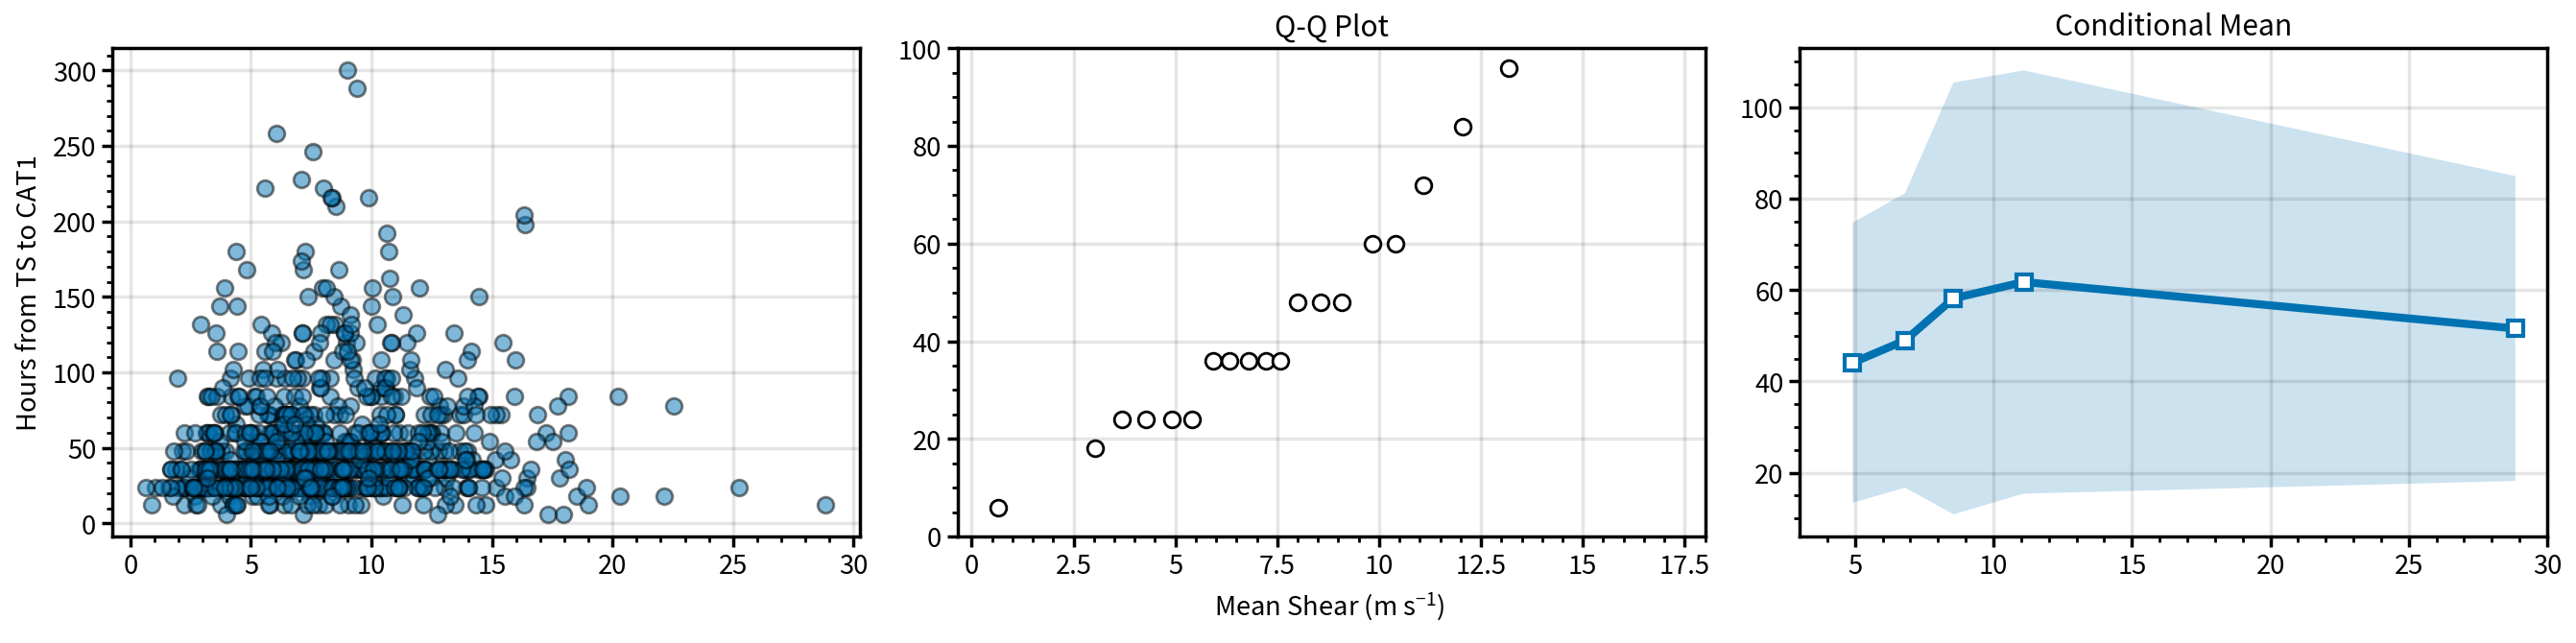

In [91]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.895,refaspect=1.531,sharex=1,sharey=1)
axs[0].scatter(filt_allnp['mean_shear_hu'],filt_allnp['time_before_hu'],linewidths=1,edgecolors='k',alpha=0.5)

percentiles = np.linspace(0,100,21)[:-1]
qn_a = np.asarray([np.percentile(filt_allnp['mean_shear_hu'],obj) for obj in percentiles])
qn_b = np.asarray([np.percentile(filt_allnp['time_before_hu'],obj) for obj in percentiles])
axs[1].plot([np.percentile(filt_allnp['mean_shear_hu'],obj) for obj in percentiles],\
         [np.percentile(filt_allnp['time_before_hu'],obj) for obj in percentiles],
         lw = 0,
         mfc = 'w',
         mec = 'k',
         marker = 'o'
        )
axs[1].format(xlim=[-0.35,18],ylim=[0,100],title='Q-Q Plot')

percentiles = np.asarray([np.percentile(filt_allnp['mean_shear_hu'],obj) for obj in np.linspace(0,100,6)])
mean = [filt_allnp.loc[(filt_allnp['mean_shear_hu']>percentiles[i]) & (filt_allnp['mean_shear_hu']<percentiles[i+1])]['time_before_hu'].mean() for i in range(len(percentiles)-1)]
std = [filt_allnp.loc[(filt_allnp['mean_shear_hu']>percentiles[i]) & (filt_allnp['mean_shear_hu']<percentiles[i+1])]['time_before_hu'].std() for i in range(len(percentiles)-1)]
axs[2].plot(percentiles[1:],np.asarray(mean),lw=3,marker='s',mfc='w',mew=1.5)
axs[2].fill_between(percentiles[1:],
                 np.asarray(mean)-np.asarray(std),
                 np.asarray(mean)+np.asarray(std),
                 alpha=0.2
                )
axs[2].format(xlim=[3,30],title='Conditional Mean',ylabel='Hours from TS to CAT1')
#x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
#plt.plot(x,x, color="k", ls="--")
axs.format(xlabel='Mean Shear (m s$^{-1}$)')
plt.savefig('./fig/full_stats_ts_ty.png',dpi=600)
plt.show()

In [92]:
allnp.sort_values('time_before_tcg').iloc[-10:]

,level_0,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,final_inten
917,78,0,2004_BONNIE,"[al022004, AL_02]",9.795623,144,9.986863,84,22.5,55.0
141,141,16,2005_SONCA,"[wp032005, WP_03]",12.861293,144,8.451216,24,11.45,97.0
87,87,12,2003_LUPIT,"[wp262003, WP_26]",6.323063,156,5.61044,36,8.775,97.0
1067,228,3,2014_HANNA,"[al092014, AL_09]",10.30023,156,4.364207,12,15.0,35.0
996,157,3,2009_GRACE,"[al092009, AL_09]",9.654966,156,14.867665,48,38.5,55.0
93,93,18,2003_KROVANH,"[wp122003, WP_12]",5.503425,156,13.939857,24,19.25,90.0
261,261,11,2011_HAIMA,"[wp062011, WP_06]",12.049198,168,14.450304,42,21.2,35.0
1045,206,10,2012_HELENE,"[al072012, AL_07]",6.739951,192,4.003308,12,20.3,40.0
1117,278,8,2018_LESLIE,"[al132018, AL_13]",7.748875,192,9.847452,84,34.3,80.0
427,427,10,2018_USAGI,"[wp332018, WP_33]",11.714389,360,9.849923,36,11.0,90.0


In [43]:
allnp.sort_values('time_before_tcg').iloc[-10:]

,level_0,index,name,id,mean_shear,time_before_tcg,lat,final_inten
141,141,16,2005_SONCA,"[wp032005, WP_03]",12.861293,144,11.45,97.0
1001,158,3,2009_GRACE,"[al092009, AL_09]",9.654966,156,38.5,55.0
87,87,12,2003_LUPIT,"[wp262003, WP_26]",6.323063,156,8.775,97.0
93,93,18,2003_KROVANH,"[wp122003, WP_12]",5.503425,156,19.25,90.0
1072,229,3,2014_HANNA,"[al092014, AL_09]",10.30023,156,15.0,35.0
261,261,11,2011_HAIMA,"[wp062011, WP_06]",12.049198,168,21.2,35.0
1050,207,10,2012_HELENE,"[al072012, AL_07]",6.739951,192,20.3,40.0
1123,280,8,2018_LESLIE,"[al132018, AL_13]",7.748875,192,34.3,80.0
1088,245,4,2016_ALEX,"[al012016, AL_01]",31.125849,204,38.0,75.0
427,427,10,2018_USAGI,"[wp332018, WP_33]",11.714389,360,11.0,90.0


In [93]:
filt_allnp.sort_values('mean_shear').iloc[-10:]

,level_0,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,final_inten
251,251,1,2011_HAITANG,"[wp212011, WP_21]",18.261235,36,18.537441,18,17.0,35.0
555,58,7,2002_JULIO,"[ep132002, EP_13]",18.280564,12,11.107983,24,16.1,40.0
604,107,1,2006_GILMA,"[ep082006, EP_08]",18.38128,12,15.923403,18,13.8,35.0
359,359,19,2015_CHAMPI,"[wp252015, WP_25]",18.665497,24,18.165656,60,14.65,97.0
858,19,5,1999_CINDY,"[al041999, AL_04]",18.927588,48,18.219015,36,13.6,97.0
362,362,22,2015_NOT_NAMED,"[wp122015, WP_12]",19.306227,48,16.325376,24,18.0,35.0
952,113,23,2005_GAMMA,"[al282005, AL_28]",20.223671,36,7.893518,126,14.3,45.0
447,447,1,2019_MUN,"[wp052019, WP_05]",21.58215,54,28.848114,12,19.1,35.0
1003,164,2,2010_IGOR,"[al112010, AL_11]",22.43281,12,13.970813,84,13.8,95.0
971,132,5,2007_OLGA,"[al172007, AL_17]",27.664701,36,25.258581,24,18.5,50.0


In [107]:
filt_allnp.sort_values('mean_shear').iloc[:10]

,level_0,index,name,id,mean_shear,time_before_tcg,lat,final_inten
702,205,0,2013_BARBARA,"[ep022013, EP_02]",0.418734,12,14.1,70.0
799,302,8,2018_CARLOTTA,"[ep042018, EP_04]",0.666327,24,15.8,55.0
282,282,14,2012_BOPHA,"[wp262012, WP_26]",0.714778,12,4.25,97.0
940,97,4,2005_BETA,"[al272005, AL_27]",0.739194,12,11.0,95.0
39,39,13,2001_LEKIMA,"[wp232001, WP_23]",1.151214,12,19.375,95.0
221,221,7,2009_KUJIRA,"[wp012009, WP_01]",1.20863,48,13.3692,92.0
556,59,5,2002_GENEVIEVE,"[ep092002, EP_09]",1.333571,24,14.0,60.0
719,222,0,2014_BORIS,"[ep022014, EP_02]",1.349594,48,14.4,40.0
90,90,15,2003_NANGKA,"[wp062003, WP_06]",1.455905,36,17.7533,45.0
710,213,8,2013_DALILA,"[ep042013, EP_04]",1.488206,36,14.2,70.0


In [ ]:
for 